# **Pairs Trading**

Pairs Trading is a market-neutral trading strategy which involves matching a long position with a short position in two securities which have a high level of positive correlation. It is a form of **statistical arbitrage** i.e it looks at the relative price movement between the two securities.

As it is a market-neutral strategy, it is independent of the trend being followed by the overall market (upwards or downwards). Instead, pairs trading works on the concept of mean-reversion. When two highly correlated securites deviate from their general trend, it is expected that they will return back to that trend in the future.

The spread between the stock prices created during the deviation serves as an opportunity for profit. One can open a long position on the stock expected to move upwards and a short position on the stock expected to move downwards. If the pair performs as expected, it is a profitable trade.

Even if the pair does not perform as expected, the trader will be able to mitigate some portion of their losses as the loss on one security will be offset by the profits on the other security. Hence, pairs trading also acts as a form of hedging and can be used to minimise losses.

## **Importing Libraries**

In [ ]:
#!pip install yfinance

In [ ]:
#!pip install pandas_ta

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from statsmodels.tsa.stattools import coint, adfuller
import pandas_ta as ta
import statsmodels
import statsmodels.api as sm

## **Importing Stock Price dataset**

For the purpose of this strategy, a lookback period of four years from 2018-2022 will be used to identify stock pairs having high positive correlation. In particular, stocks from the banking sector will be considered and hence the stocks of the BANK NIFTY index have been taken.


In [2]:
start_date = "2018-12-31"
end_date = "2022-12-31"

stocks = ["XOM", "SLB", "EOG", "COP", "PXD", "MPC", "WMB", "PSX", "CVX", "KMI", "SHEL", "TTE", "BP", "EQNR", "ENB", "EPD"]

In [5]:
stock_data =  yf.download(stocks, start = start_date ,end= end_date)['Adj Close']
stock_data.head()

[*********************100%%**********************]  16 of 16 completed


,BP,COP,CVX,ENB,EOG,EPD,EQNR,KMI,MPC,PSX,PXD,SHEL,SLB,TTE,WMB,XOM
Date,,,,,,,,,,,,,,,,
2018-12-31,28.775618,52.085072,87.310043,22.587322,70.855385,16.738766,15.857387,11.292879,49.148251,69.557106,103.329491,46.926552,31.505131,38.262512,16.367016,52.801018
2019-01-02,29.284052,52.945507,88.834908,22.950699,73.617767,17.011051,16.194462,11.601268,49.672966,71.147667,105.513618,47.788258,32.483124,38.709816,16.641661,53.962509
2019-01-03,29.451000,51.943062,87.133476,23.074245,73.097801,17.324183,16.231915,11.535184,48.948360,70.162651,105.851433,47.683556,32.832405,38.797813,16.782688,53.133991
2019-01-04,30.376791,53.254574,88.939240,23.706514,76.307053,18.045740,16.696329,11.924340,51.347050,73.343781,109.434021,48.762703,34.133472,39.934387,17.480417,55.093025
2019-01-07,30.475456,53.020683,90.094902,24.353319,76.786407,18.460974,16.838642,12.181330,51.855106,73.852432,111.814575,48.827133,35.076523,39.861069,17.925781,55.379513


## **Identifying stock pairs**

### **Cointegration**

Cointegration is a statistical method which is used to identify the correlation between two non-stationary time series in the long run or over a specified period.

**Finding stock pairs with cointegrated time series:**

In [6]:
def cointegration_test(stock_data, stocks):
    N = stock_data.shape[1]
    pvalues = np.ones((N, N))
    stock_pairs = []

    for i in range(N):
      for j in range(N):
        if i == j:
          continue

        result = coint(stock_data[stocks[i]], stock_data[stocks[j]])
        pval = result[1]
        pvalues[i][j] = pval

        if(pval < 0.05 and stocks[i] != stocks[j]):                   # Cutoff threshold for 95% confidence
          stock_pairs.append((pval, (stocks[i], stocks[j])))

    return pvalues, stock_pairs

<AxesSubplot: >

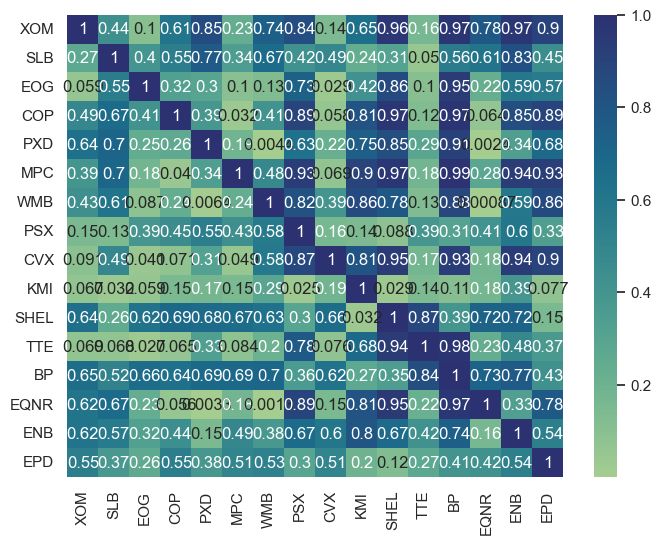

In [7]:
pvalues, stock_pairs = cointegration_test(stock_data, stocks)
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
sns.heatmap(pvalues, xticklabels = stocks, yticklabels = stocks, cmap = 'crest',  annot = True)

The pairs of stocks having a cointegration are those with a p-value less than the threshold of 0.05.
P-value can be considered as a measure of the strength of cointegration between the two series. A lower p-value indicates a stronger cointegration

In [8]:
print(min(stock_pairs))
cointegrated_stock_pair = {}
cointegrated_stock_pair['first'] = min(stock_pairs)[1][0]
cointegrated_stock_pair['second'] = min(stock_pairs)[1][1]

(0.0008713381243802025, ('WMB', 'EQNR'))


Find the ratio of the average stock prices between the two cointegrated stocks such that the following plot more clearly shows the correlation between the two stock's prices overtime

In [9]:
stock_1_avg_price = stock_data[cointegrated_stock_pair['first']][1]
stock_2_avg_price = stock_data[cointegrated_stock_pair['second']][1]

if stock_1_avg_price > stock_2_avg_price:
    price_ratio = stock_1_avg_price / stock_2_avg_price
else: 
    price_ratio = stock_2_avg_price / stock_1_avg_price

**Selected pair: Bank of America (BAC) and PNC Financial Services Group (PNC)**

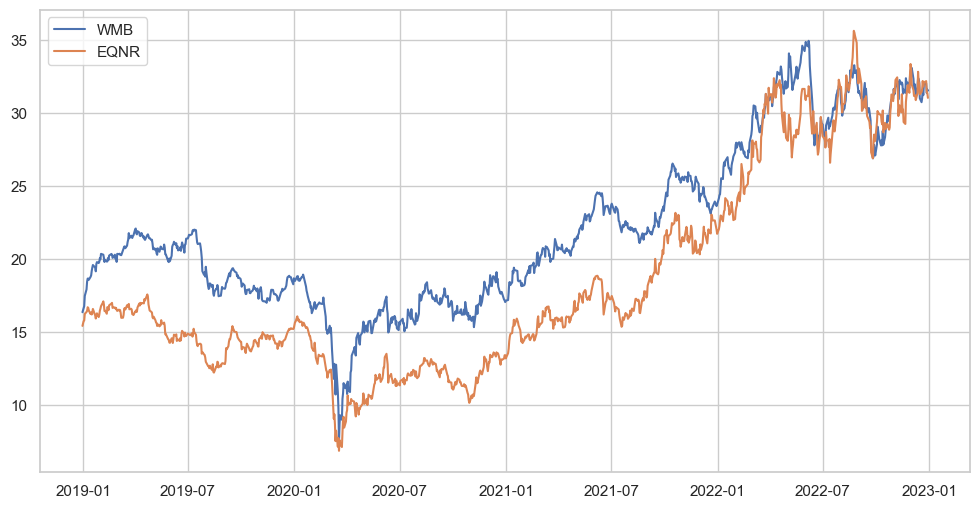

In [12]:
plt.figure(figsize = (12, 6))
plt.plot(stock_data[cointegrated_stock_pair['first']], label = cointegrated_stock_pair['first'])
plt.plot(stock_data[cointegrated_stock_pair['second']]/price_ratio, label = cointegrated_stock_pair['second'])
plt.legend()
plt.show()

### **Testing Data**

The strategy will use a 6 month testing period from January 2023 to June 2023. The spread between the prices of the two stocks will be used to determine points of entry and exit for the pairs trade.

[*********************100%%**********************]  2 of 2 completed


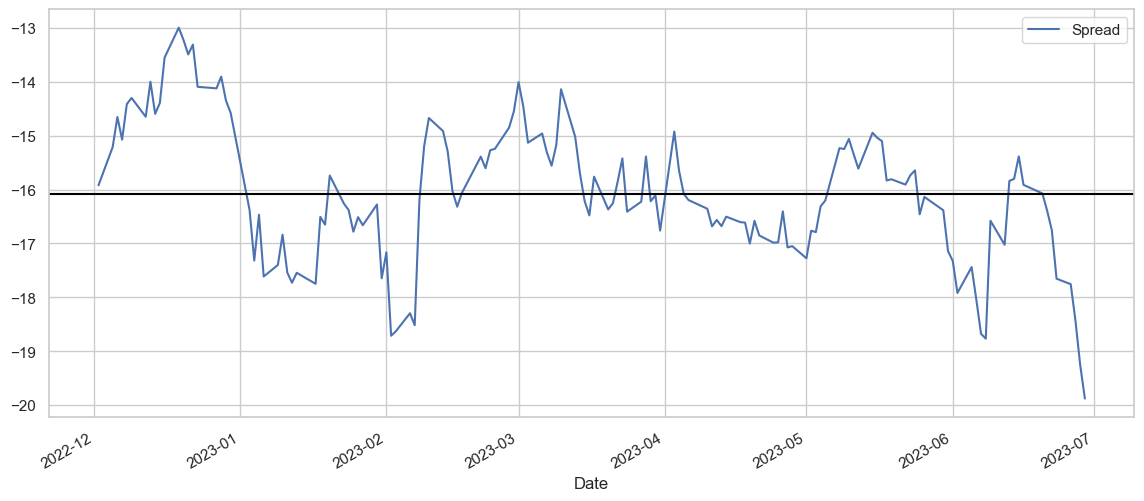

In [13]:
#stock_pair = ['KOTAKBANK.NS', 'HDFCBANK.NS']
stock_pair_names = list(cointegrated_stock_pair.values())
asset_pairs =  yf.download(stock_pair_names, start="2022-12-02" ,end= "2023-06-30")['Adj Close']

S1=asset_pairs[stock_pair_names[0]]
S2=asset_pairs[stock_pair_names[1]]

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1[stock_pair_names[0]]
b = results.params[stock_pair_names[0]]

spread = S2 - b * S1
spread.plot(figsize=(14, 6))
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

## **Z-Score**

A Z-score is a numerical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean. Z-scores also make it possible to adapt values from data sets having a very different ranges to make scores that are comparable.
Essentially, z-scores can shrink a large range of values into a much smaller range which is easier to handle.

Zscore.svg

𝒳 = series

μ = series mean

σ = series standard deviation

In [14]:
def zscore(series):
    lookback = 20
    scores = []
    for i in range(lookback, len(series)):
      window = series[i-lookback:i]
      scores.append((series[i]-window.mean())/window.std())
    return pd.Series(scores, index = series.index[lookback:])


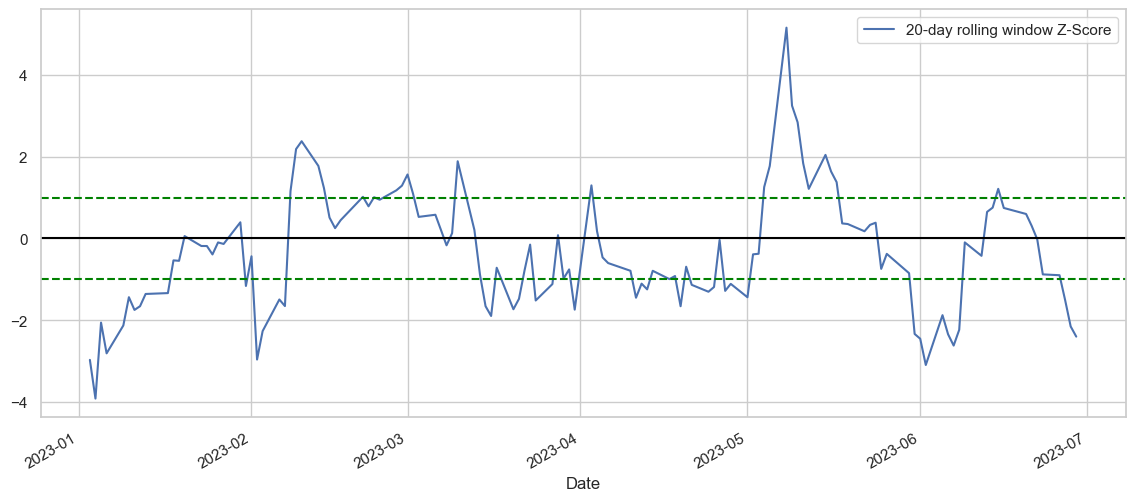

In [15]:
zscore(spread).plot(figsize=(14, 6))
plt.axhline(0.0, color='black')
plt.axhline(1.0, color='green', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['20-day rolling window Z-Score'])

## **Trading Strategy**

Implementation of a simple mean-reversion based strategy. The threshold levels for the Z-score are taken as +1 and -1. Whenever the Z-score value rises above +1, it is expected to fall in the future and a short position is taken on the pair. Similarly, when the Z-score value falls below -1, it is expected to rise in the future and a long position is taken on the pair.


In [16]:
def generate_trade_signals(S1, S2, spread):
  signals = pd.DataFrame()
  signals['price1'] = S1
  signals['price2'] = S2
  signals['spread'] = spread
  signals['zscore'] = zscore(spread)

  signals.dropna(inplace = True)

  signals['signal1'] = np.select([signals['zscore'] > 1, signals['zscore'] < -1], [1, -1], default = 0)
  signals['position1'] = signals['signal1'].diff()
  signals['signal2'] = -signals['signal1']
  signals['position2'] = signals['signal2'].diff()

  return signals

In [17]:
trade_signals = generate_trade_signals(S1, S2, spread)
trade_signals.dropna(inplace = True)
trade_signals

,price1,price2,spread,zscore,signal1,position1,signal2,position2
Date,,,,,,,,
2023-01-04,31.003157,28.370653,-17.316058,-3.920381,-1,0.0,1,0.0
2023-01-05,30.686899,28.753559,-16.467110,-2.060182,-1,0.0,1,0.0
2023-01-06,31.204418,28.370653,-17.612640,-2.812641,-1,0.0,1,0.0
2023-01-09,31.271503,28.682217,-17.399934,-2.130939,-1,0.0,1,0.0
2023-01-10,30.801901,28.553925,-16.836213,-1.437755,-1,0.0,1,0.0
...,...,...,...,...,...,...,...,...
2023-06-23,30.189173,26.833782,-17.653430,-0.879448,0,0.0,0,0.0
2023-06-26,30.662882,27.429459,-17.755818,-0.899639,0,0.0,0,0.0
2023-06-27,30.958952,27.193079,-18.428491,-1.506463,-1,-1.0,1,1.0


### **Visualising the positions**

**1) Trades on the pair**

In [18]:
def plot_pair_trades(trade_signals):
  fig = plt.figure(figsize=(14, 6))
  bx = fig.add_subplot(111)
  series = bx.plot(trade_signals['zscore'], c='#4abdac')
  long = bx.plot(trade_signals['zscore'][trade_signals['position1'] == -1], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)
  short = bx.plot(trade_signals['zscore'][trade_signals['position1'] == 1], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)
  stock1 = stock_pair_names[0]
  stock2 = stock_pair_names[1]
  plt.title(f'{stock2} / {stock1}')
  plt.legend(['Z-Score', 'Long', 'Short'])

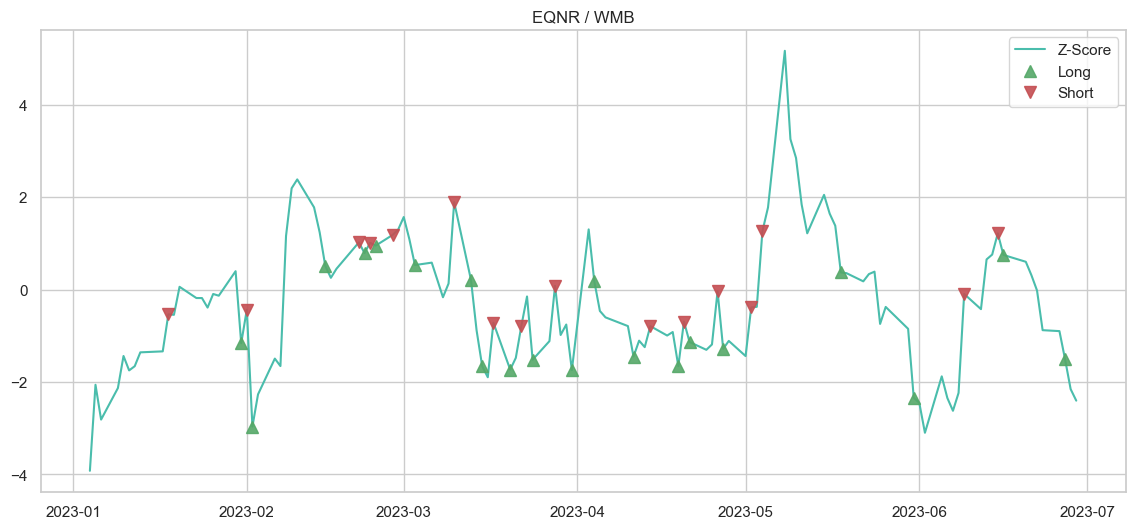

In [19]:
plot_pair_trades(trade_signals)

*   **Long position => buy PNC Financial Services and sell Bank of America**
*   **Short position => sell PNC Financial Services and buy Bank of America**

**2) Trades on First Stock**

In [21]:
def plot_trades_1(signals):
  fig = plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price1'], c='#4abdac')
  u1 = bx.plot(signals['price1'][signals['position1'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2, = bx.plot(signals['price1'][signals['position1'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair_names[0])
  plt.legend(['Price', 'Long', 'Short'])

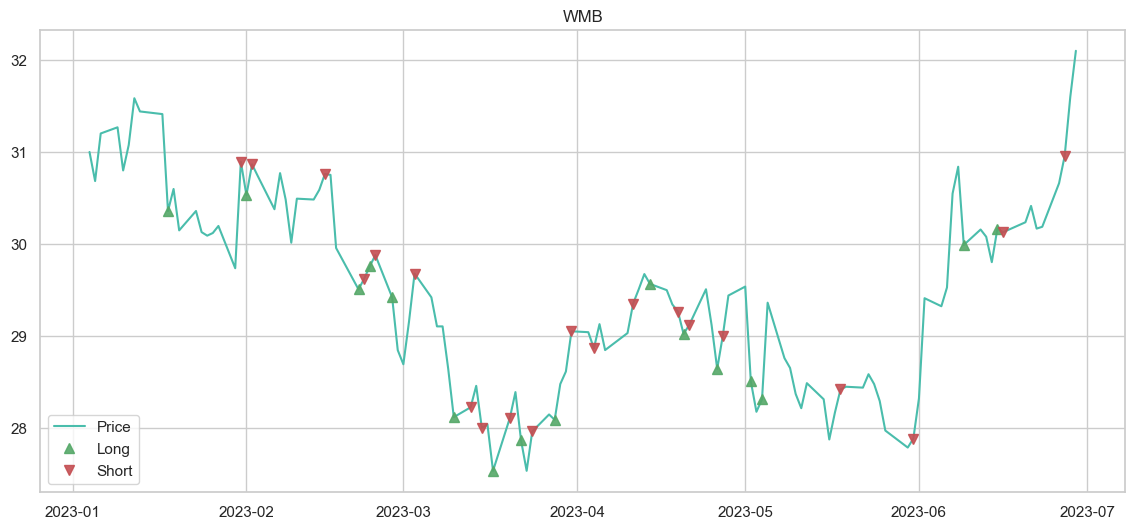

In [22]:
plot_trades_1(trade_signals)

**3) Trades on Second Stock**

In [23]:
def plot_trades_2(signals):
  fig=plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price2'], c='#4abdac')
  u1 = bx.plot(signals['price2'][signals['position2'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2 = bx.plot(signals['price2'][signals['position2'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair_names[1])
  plt.legend(['Price', 'Long', 'Short'])

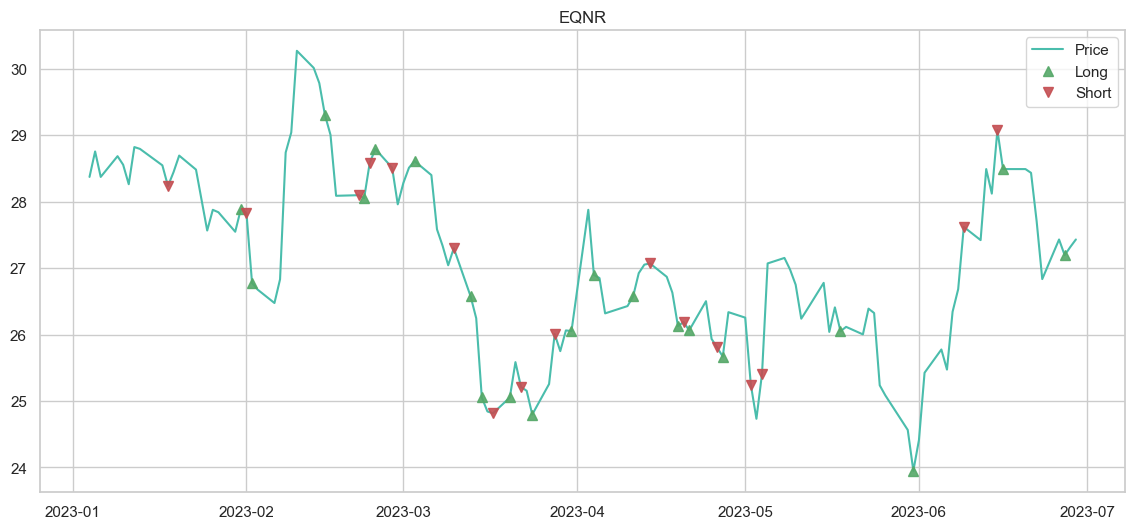

In [24]:
plot_trades_2(trade_signals)

## **Portfolio Performance**

### **PnL Calculation**

In [25]:
def pnl_calculation(signals):

  initial_capital = 50000

  # Shares to buy for each stock
  shares1 = initial_capital// (signals['price1'][0])
  shares2 = initial_capital// (signals['price2'][0])

  #PnL for stock 1
  portfolio = pd.DataFrame()
  portfolio['holdings1'] = signals['position1'].cumsum() * signals['price1'] * shares1
  portfolio['cash1'] = initial_capital - (signals['position1'] * signals['price1'] * shares1).cumsum()
  portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total1'].pct_change()

  # PnL for stock 2
  portfolio['holdings2'] = signals['position2'].cumsum() * signals['price2'] * shares2
  portfolio['cash2'] = initial_capital - (signals['position2'] * signals['price2'] * shares2).cumsum()
  portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
  portfolio['return2'] = portfolio['total2'].pct_change()

  # Total PnL
  portfolio['total'] = portfolio['total1'] + portfolio['total2']
  portfolio = portfolio.dropna()

  return portfolio


In [26]:
portfolio = pnl_calculation(trade_signals)
portfolio.head()

,holdings1,cash1,total1,return1,holdings2,cash2,total2,return2,total
Date,,,,,,,,,
2023-01-05,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0
2023-01-06,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0
2023-01-09,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0
2023-01-10,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0
2023-01-11,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0


In [27]:
def plot_portfolio_value(portfolio):

  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  l1, = ax.plot(portfolio['total'], c='g')
  ax.set_ylabel('Asset Value')
  ax.yaxis.labelpad=15
  ax.set_xlabel('Date')
  ax.xaxis.labelpad=15
  plt.title('Portfolio Performance PnL')
  plt.legend(['Total Portfolio Value'])

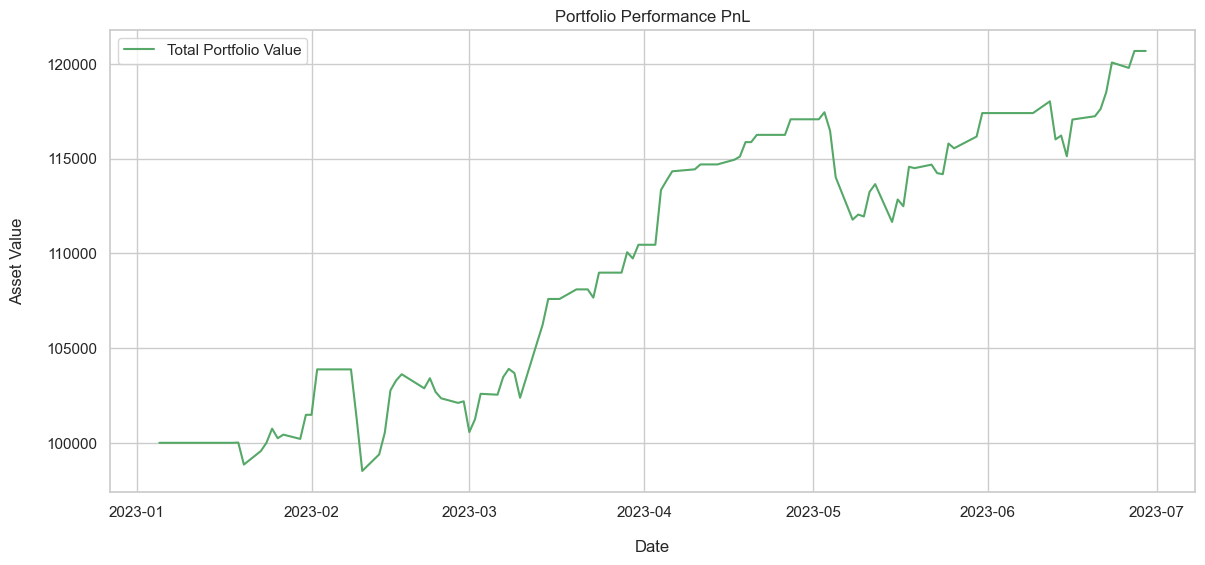

In [28]:
plot_portfolio_value(portfolio)

## **Portfolio Returns**

In [29]:
def calculate_cagr(portfolio):

  final_portfolio = portfolio['total'].iloc[-1]
  initial_portfolio = portfolio['total'].iloc[0]
  delta = len(portfolio.index)
  print('Number of trading days = ', delta)
  YEAR_DAYS = 252
  returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
  return returns

In [30]:
print('CAGR = {:.3f}%' .format(calculate_cagr(portfolio) * 100))

Number of trading days =  121
CAGR = 47.921%


Returns are also compared to a benchmark to assess the performance of the trading strategy in comparison to the overall market. For the purpose of this strategy, the KBW Nasdaq Bank Index is taken as a benchmark.

[*********************100%%**********************]  1 of 1 completed


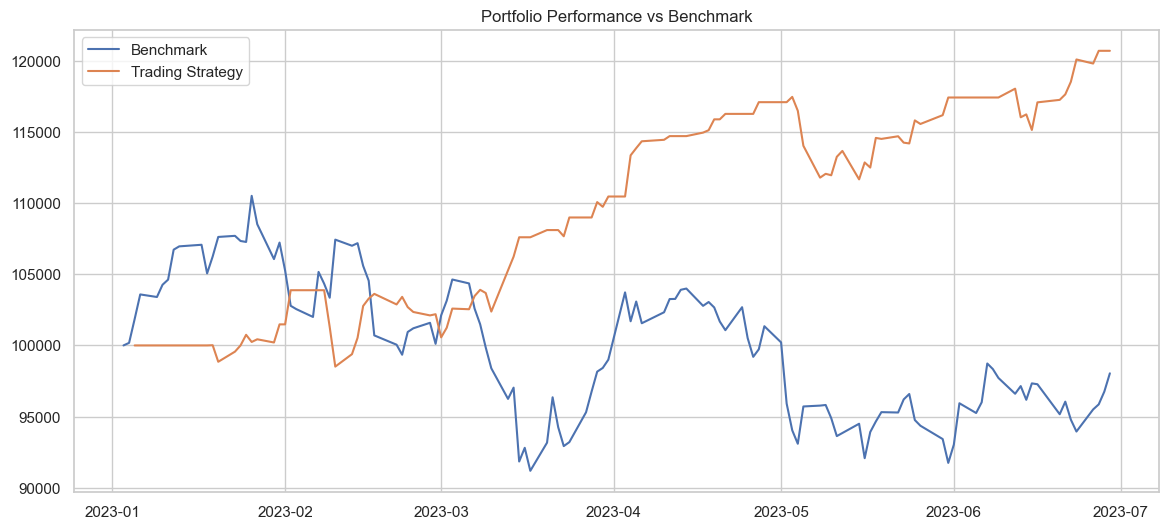

In [31]:
benchmark_name = 'VDE'
index = yf.download(benchmark_name, start = '2023-01-01', end = '2023-06-30')['Adj Close']
shares = 100000/index[0]

plt.figure(figsize = (14, 6))
plt.plot(index*shares)
plt.plot(portfolio['total'])
plt.title('Portfolio Performance vs Benchmark')
plt.legend(['Benchmark', 'Trading Strategy'])

In [32]:
cagr_index = (index.iloc[-1] / index[0])**(252/len(index)) - 1
print("CAGR of " + benchmark_name + ":", np.round(cagr_index*100, 3), "%")
cagr_portfolio = (portfolio['total'][-1] / portfolio['total'][0]) ** (252/len(portfolio)) - 1
print("CAGR of trading strategy:", np.round(cagr_portfolio*100, 3), "%")

CAGR ofVDE: -3.97 %
CAGR of trading strategy: 47.921 %
